In [12]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense,Conv2D,Flatten

In [13]:
train="../test_sample/train"
test="../test_sample/test"
valid="../test_sample/valid"

In [14]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths 
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [15]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

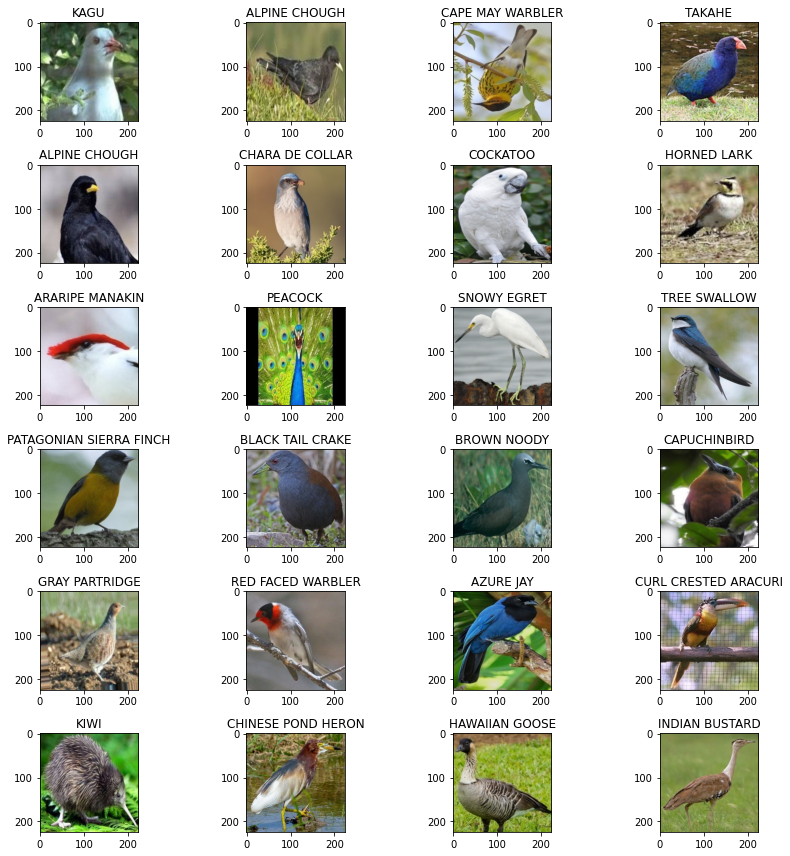

In [16]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()   

In [17]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

In [18]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32
)

Found 54652 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.
Found 1875 validated image filenames belonging to 375 classes.


In [19]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False#We don't want to train again th resnet

94781440/94765736 [==============================] - 27s 0us/step


In [24]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(375, activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
mo_fit=model.fit(train_image,validation_data=valid_image,epochs=5)

Epoch 1/5
 247/3416 [=>............................] - ETA: 28:29 - loss: 5.2819 - accuracy: 0.0617

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(mo_fit.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()